# Sprint11課題 深層学習スクラッチディープニューラルネットワーク



## この課題の目的

スクラッチを通してニューラルネットワークの発展的内容を理解する。

# スクラッチによる実装

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装する。

前回作成した3層のニューラルネットワークを、クラスを活用することで、任意の構成に拡張しやすいコードに書き換える。

その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていく。

このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指す。

### 新たなニューラルネットワーク分類器のクラスを作成する

Sprint10で作成したものとは別に、ニューラルネットワーク分類器のクラスScratchDeepNeuralNetrowkClassifierを作成すること。

### 層などのクラス化

#### コーディング

クラスにまとめて行くことで、構成を変更しやすい実装とする。

#### 手を加える箇所

- 層の数
- 層の種類（今後は畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成する。

In [2]:
# 数値演算
import numpy as np

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns

# 機械学習
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# データセットの準備
from keras.datasets import mnist

Using TensorFlow backend.


## 【問題1】全結合層のクラス化

#### コーディング

- コンストラクタで重みやバイアスを初期化をし、フォワードとバックワードのメソッドを用意する。

- 重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要となる。

- インスタンスも引数として渡すことができる。
    - 初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われる。
    - 渡すインスタンスを変えれば、初期化方法が変えられる。

- 引数として自身のインスタンスselfを渡すこともできる。
    - これを利用してself = self.optimizer.update(self)という風に層の重みの更新が可能。
    - 更新に必要な値は複数あるが、全て全結合層が持つインスタンス変数にすることができる。

In [ ]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    
    Paramters
    ----------
    n_nodes1 : int
        前の層のノード数
        
    n_nodes2 : int
        後の層のノード数
    
    initializer : class
        パラメータ初期値のインスタンス("SimpleInitializer" or "Xavier" or "He")
    
    optimizer : class
        最適化手法のインスタンス（"SGD" or "AdaGrad"）
    
    Attributes
    ----------
    self.forward_Z : 次の形のndarray, shape(batch_size, features)
        入力値
    
    self.dB : 次の形のndarray, shape(n_nodes2)
        バイアスに流す勾配
    
    self.dW : 次の形のndarray, shape(n_nodes1, n_nodes2)
        重みに流す勾配
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        
        self.initializer = initializer
        self.optimizer = optimizer
        
        self.W = initializer.W(n_nodes1, n_nodes2) # 重みの初期値
        self.B = initializer.B(n_nodes2) # バイアスの初期値
        
        self.forward_Z = None
        self.dB = None
        self.dW = None
    
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        Z : 次の形のndarray, shape(batch_size, n_nodes1)
            入力

        Returns
        ----------
        A : 次の形のndarray, shape(batch_size, n_nodes2)
            出力
            
        """
        self.forward_Z = Z.copy()
        
        A = np.dot(self.forward_Z, self.W) + self.B
        
        return A
    
    
    def backward(self, dA):
        """
        バックプロパゲーション
        
        Parameters
        ----------
        dA : 次の形のndarray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
        
        Returns
        ----------
        dZ : 次の形のndarray, shape(batch_size, n_nodes1)
            前に流す勾配
        
        """
        self.dB = dA
        
        self.dW = np.dot(self.forward_Z.T, dA)
        
        dZ = np.dot(dA, self.W.T)
        
        # 重み、バイアスを更新
        self = self.optimizer.update(self)
        
        return dZ

## 【問題2】初期化方法のクラス化

- 全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにする。
- 標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむ。
- これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにする。

In [ ]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    
    Parameters
    ----------
    sigma : float
        ガウス分布の標準偏差
    
    """
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
            重みの初期値
            
        """

        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
        
        Returns
        ----------
        B : 次の形のndarray, shape(n_nodes2)
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B


## 【問題3】最適化手法のクラス化

- 最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡す。
- バックワードのときにself = self.optimizer.update(self)のように更新できるようにする。
- これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成すること。

In [ ]:
class SGD:
    """
    確率的勾配降下法
    
    Parameters
    ----------
    lr : float 
        学習率
    
    """
    
    def __init__(self, lr):
        self.lr = lr
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        
        Parameters
        ----------
        layer : class
            更新前の層のインスタンス(FC)
        
        
        Returns
        ----------
        layer : class
            更新後の層のインスタンス(FC)
        
        """
        
        layer.W = layer.W - self.lr * layer.dW/ layer.dB.shape[0]
        
        layer.B = layer.B - self.lr * np.mean(layer.dB, axis=0)
        
        return layer


## 【問題4】活性化関数のクラス化
活性化関数もクラス化を行なってください。

上記サンプルコード3ではソフトマックス関数のバックプロパゲーションに交差エントロピー誤差の計算も含む実装を想定しています。

In [ ]:
class Sigmoid:
    """
    シグモイドレイヤー
        
    """
    def __init__(self, ):
        
        self.forward_A = None
    
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        A : 次の形のndarray, shape(batch_size, features)
            入力
        
        """
        self.forward_A = A
        
        self.Z = 1 / (1 + np.exp(-A))
        
        return self.Z

    
    def backward(self, dZ):
        """
        バックプロパゲーション（微分）
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape(batch_size, features)
            後の層の勾配
        
        """
        
        return dZ * (1 - self.Z) * self.Z
    
    

class Tanh:
    """
    ハイパボリックタンジェントレイヤー
    
    """
    
    def __init__(self, ):
        
        self.forward_A = None
        self.Z = None
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        A : 次の形のndarray, shape(batch_size, features)
            入力
        
        """
        self.forward_A = A
        
        self.Z = np.tanh(A)
        
        return self.Z

    
    def backward(self, dA):
        """
        バックプロパゲーション（微分）
        
        Parameters
        ----------
        dA : 次の形のndarray, shape(batch_size, features)
            後の層の勾配
        
        """
        
        return dA * (1 - self.Z**2)  
    

class Softmax:
    """
    ソフトマックス関数
    
    """
    
    def __init__(self, ):
        
        self.Z = None
    
    def forward(self, X):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        X : 次の形のndarray, shape(batch_size, classes)
        
        Returns
        ----------
        Z : 次の形のndarray, shape(batch_size, classes)
            予測確率
        
        """
        c = np.max(X)
        
        # オーバーフロー対策を実施（要素の最大値を各要素から控除）
        self.Z = np.exp(X - c) / np.sum(np.exp(X - c), axis=1).reshape(-1,1)
        
        return self.Z
    
    
    def backward(self, Z, Y):
        """
        バックプロパゲーション（微分）
        
        Parameters
        ----------
        Z : 次の形のndarray, shape
            予測確率（＝第３層におけるフォワードプロパゲーション）
        
        Y : 次の形のndarray, shape(batch_size, classes)
            正解値
        
        Returns
        ----------
        dA : 次の形ndarray, shape(batch_size, classes)
            勾配
        
        loss : float
            交差エントロピー誤差
            
        """
        
        dA = Z - Y
        
        # 交差エントロピー誤差
        loss = - np.sum(Y * np.log(Z + 1e-7)) / Y.shape[0]
        
        return dA, loss

## 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装する。

ReLUは以下の数式。

<div style="text-align: center;">
$
% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$</div>


$x$  : ある特徴量。スカラー

実装上はnp.maximumを使い配列に対してまとめて計算が可能。

[numpy.maximum — NumPy v1.15 Manual]()

一方、バックプロパゲーションのための $x$に関する$f(x)$ の微分は以下のようになる。

<div style="text-align: center;">
$
% <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$</div>

数学的には微分可能ではないですが、 $x=0$のとき $0$とすることで対応する。

フォワード時の $x$の正負により、勾配を逆伝播するかどうかが決まる。

In [ ]:
class ReLU:
    """
    ReLUレイヤー
    
    """
    def __init__(self, ):
        
        self.forward_A = None
        self.Z = None
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        A : 次の形のndarray, shape(batch_size, features)
            入力
        
        """
        self.forward_A = A
        
        self.Z = np.maximum(A, 0)
        
        return self.Z

    
    def backward(self, dZ):
        """
        バックプロパゲーション（微分）
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape(batch_size, features)
            後の層の勾配
        
        """
        
        return dZ * np.where(self.forward_A > 0, 1, 0)

## 【問題6】重みの初期値

ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきた。

しかし、一般的に良い初期値の取り方が知られている。

シグモイド関数やハイパボリックタンジェント関数のときはXavierの初期値（またはGlorotの初期値）、ReLUのときはHeの初期値が使われる。

XavierInitializerクラスと、HeInitializerクラスを作成する。

それぞれの初期化方法における σ は次の式で求められる。

「Xavierの初期値」

<div style="text-align: center;">
$
\sigma = \frac{1}{\sqrt{n}}
$</div>

$n$ : 前の層のノード数

「Heの初期値」

<div style="text-align: center;">
$
\sigma = \sqrt{\frac{2}{n}}
$</div>

$n$ : 前の層のノード数

In [ ]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    
    Parameters
    ----------
    sigma : float
        ガウス分布の標準偏差
    
    """
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
            重みの初期値
            
        """

        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
 
        Returns
        ----------
        B : 次の形のndarray, shape(n_nodes2)
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B



class XavierInitializer:
    """
    Xavierによる初期化
    
    Parameters
    ----------
    sigma : float
        標準偏差
    
    """
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
            重みの初期値
            
        """
        self.sigma = np.sqrt(1/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
            
        
        Returns
        ----------
        B : 次の形のndarray, shape()
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

    
class HeInitializer:
    """
    Heによる初期化
    
    Parameters
    ----------
    sigma : float
        標準偏差
    
    """
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape()
            重みの初期値
            
        """
        self.sigma = np.sqrt(2/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
            
        
        Returns
        ----------
        B : 次の形のndarray, shape()
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

## 【問題7】最適化手法

学習率は学習の良し悪しにとって重要なハイパーパラメータであり、これを学習過程で変化させていく方法が現在では一般的。
様々な手法が提案されているが、今回はその中でも基本的な、AdaGradを実装する。

まず、これまで使ってきたSGDを確認する。

<div style="text-align: center;">
$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$</div>

$α$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）

$\frac{∂L}{∂Wi}$: $Wi$に関する損失 $L$の勾配

$\frac{∂L∂}{Bi}$ : $B_i$に関する損失 $L$の勾配

$E()$ : ミニバッチ方向にベクトルの平均を計算

続いて、AdaGradを確認する。

更新された分だけその重みに対する学習率を徐々に下げていく。

イテレーションごとの勾配の二乗和 $H$ を保存しておき、その分だけ学習率を小さくする。

学習率は重み一つひとつに対して異なる。

<div style="text-align: center;">
$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$</div>

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）

$H′_i$ : 更新した $H_i$

AdaGradクラスを作成し、上記の数式にもとづいて実装すること。

In [3]:
class AdaGrad:
    """
    AdaGradによる最適化
    
    Parameters
    ----------
    lr : float
        学習率
    
    Attributes
    ----------
    self.H : 次の形のndarray, shape()
        勾配の二乗和
    
    """
    
    def __init__(self, lr):
        
        self.lr = lr
        self.H = 0
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        Returns
        ----------
        layer : 更新後の層のインスタンス
        
        """
        
        self.H = self.H + np.sum(layer.dW, axis=0)**2
        
        layer.W = layer.W - self.lr * np.sqrt(1/ self.H) * layer.dW/ layer.dB.shape[0]
        
        layer.B = layer.B - self.lr * np.sqrt(1/ self.H) * np.mean(layer.dB, axis=0)
        
        return layer

## ScratchDeepNeuralNetworkClassifierの実装

In [4]:
# データを格納
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [5]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= np.max(X_train)
X_test /= np.max(X_test)

In [6]:
# 学習用データ、テストデータの生成

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(48000, 784)
(12000, 784)
(48000,)
(12000,)


In [12]:
np.unique(y_train).shape

(10,)

In [6]:
# 演算処理
import numpy as np

# 可視化
import matplotlib.pyplot as plt

# 機械学習
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

# プログレスバー
from tqdm import tqdm_notebook as tqdm

class ScratchDeepNeuralNetworkClassifier:
    """
    ディープニューラルネットワークのスクラッチ実装
    
    Parameters
    ----------
    activation : str
        活性化関数の種類
    
    batch_size : int
        ミニバッチのサイズ
    
    epoch : int
        エポック数
    
    initializer : str
        パラメータ初期値を生成するクラス
    
    lr : float
        学習率
        
    n_nodes1 : int
        １層目のレイヤー数
        
    n_nodes2 : int
        2層目のレイヤー数
    
    n_output : int
        出力数
    
    optimizer : str
        最適化手法
    
    random_state_batch : int
        ミニバッチ生成時の乱数のシード値
    
    random_state_para : int
        パラメータ初期値生成時の乱数のシード値
    
    sigma : float
        SimpleInitializerの標準偏差
    
    verbose : bool
        学習過程の出力
    
    Attributes
    ----------
    self.train_loss : list
        学習用データに基づく交差エントロピー損失
    
    self.val_loss : list
        検証用データに基づく交差エントロピー損失
    
    self.y_pred : 次の形のndarray, shape(batch_size)
        予測値
    """
    
    def __init__(self, activation="Tanh", batch=30, initializer="Simple", n_epochs = 10, lr=1e-2, n_nodes1=400, n_nodes2=200, optimizer="SGD", sigma=0.01, verbose=False):
        
        # パラメータ
        self.activation = activation
        self.batch = batch
        self.initializer = initializer
        self.lr = lr
        self.n_epochs = n_epochs
        self.features = 784
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = 10
        self.optimizer = optimizer
        self.sigma = sigma
        self.verbose = verbose
        
        
        # パラメータ初期値
        if self.initializer == "Simple":
            initializer1 = SimpleInitializer(self.sigma)
            initializer2 = SimpleInitializer(self.sigma)
            initializer3 = SimpleInitializer(self.sigma)
        elif self.initializer == "Xavier":
            initializer1 = XavierInitializer()
            initializer2 = XavierInitializer()
            initializer3 = XavierInitializer()
        elif self.initializer == "He":
            initializer1 = HeInitializer()
            initializer2 = HeInitializer()
            initializer3 = HeInitializer()
        
        # 最適化手法
        if self.optimizer == "SGD":
            optimizer1 = SGD(self.lr)
            optimizer2 = SGD(self.lr)
            optimizer3 = SGD(self.lr)
        elif self.optimizer == "AdaGrad":
            optimizer1 = AdaGrad(self.lr)
            optimizer2 = AdaGrad(self.lr)
            optimizer3 = AdaGrad(self.lr)
        
        # レイヤー（インスタンス生成）
        self.FC1 = FC(self.features, self.n_nodes1, initializer1, optimizer1)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer2, optimizer2)
        self.FC3 = FC(self.n_nodes2, self.n_output, initializer3, optimizer3)
            
        # 活性化関数
        self.activation3 = Softmax()
        if self.activation == "Sigmoid":
            self.activation1 = Sigmoid()
            self.activation2 = Sigmoid()
        elif self.activation == "Tanh":
            self.activation1 = Tanh()
            self.activation2 = Tanh()
        elif self.activation == "ReLU":
            self.activation1 = ReLU()
            self.activation2 = ReLU()
        
        
        # 損失
        self.train_loss = []
        self.val_loss = []
        
        # 予測値
        self.y_pred = None
        
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        学習
        
        Parameters
        ----------
        X_train : 次の形のndarray, shape(batch_size, features)
            学習用データ（特徴量）
            
        y_train : 
            学習用データ（正解値）
            
        X_val : 
            検証用データ（特徴量）
            
        y_val : 次の形のndarray, shape(batch_size)
            検証用データ（正解値）
        
        """
        
        
        # 軸追加
        if X_train.ndim == 1:
            X_train = X_train[:, np.newaxis]
        if y_train.ndim == 1:
            y_train = y_train[:, np.newaxis]
        if X_val.ndim == 1:
            X_val  = X_val[:, np.newaxis]
        if y_val.ndim == 1:
            y_val = y_val[:, np.newaxis]
        
        # One-Hot Encoding
        enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
        y_train = enc.fit_transform(y_train[:, np.newaxis]) # 学習用データ
        if y_val is not None:
            y_val = enc.fit_transform(y_val[:, np.newaxis]) # 検証用データ
        
        # 選択した最適化手法による学習を繰り返す
        for i in tqdm(range(self.n_epochs)):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size = self.batch, seed = 0)
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # フォワードプロパゲーション
                A1 = self.FC1.forward(mini_X_train) # インスタンス変数にmini_X_trainを格納
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1) # インスタンス変数にZ1を格納
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2) # インスタンス変数にZ2を格納
                Z3 = self.activation3.forward(A3)
                
                # バックプロパゲーション
                dA3, train_loss = self.activation3.backward(Z3, mini_y_train)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1)
                
                self.train_loss.append(train_loss)
                
                if self.verbose == True:
                    print("train_loss : {}".format(train_loss))
                
                # 検証用データを用いる場合、損失を計算する
                if (X_val is not None) and (y_val is not None):
                    # フォワードプロパゲーション
                    A1_val = self.FC1.forward(X_val)
                    Z1_val = self.activation1.forward(A1_val)
                    A2_val = self.FC2.forward(Z1_val)
                    Z2_val = self.activation2.forward(A2_val)
                    A3_val = self.FC3.forward(Z2_val)
                    Z3_val = self.activation3.forward(A3_val)
                    
                    dA3_val, val_loss = self.activation3.backward(Z3_val, y_val) # 損失を計算
                    
                    # 損失を格納
                    self.val_loss.append(val_loss / len(X_val))
                
                    # 学習過程を表示
                    if self.verbose == True:
                        print("val_loss : {}".format(val_loss))

            
    def predict(self, X):
        """
        予測
        
        Parameters
        ----------
        X : 次の形のndarray, shape(batch_size, features)
            テストデータ
            
            
        Returns
        ----------
        y_pred : 次の形のndarray, shape(batch_size, class)
            予測
        """
        
        # フォワードプロパゲーション
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        # 確率が最大のインデックスを返す
        y_pred = np.argmax(Z3, axis=1)
        
        self.y_pred = y_pred
        
        return y_pred


    def show_learning_curve(self,):
        """
        学習曲線を描画する
        
        """
        iteration = np.arange(len(self.train_loss))
        train_loss = self.train_loss
        val_loss = self.val_loss
        
        plt.style.use("seaborn-whitegrid")
        
        # 損失の推移を描画
        plt.plot(iteration, train_loss, label = "average_train_loss", color="b")
        #plt.plot(iteration, val_loss, label="average_val_loss", color="r")
        plt.xlabel("epoch * iteration")
        plt.ylabel("average_cross_entropy_loss")
        plt.title("Learning Curve : value of cost function")
        plt.legend(loc="best")
        plt.show()

        
    def show_accuracy(self, y):
        """
        予測の正解率をheatmapで可視化する関数
        
        Parameters
        -------------
        y : 次の形のndarray, shape(batch_size)
            正解ラベル
        
        """
        
        # カウント
        true_false  = np.zeros(100).reshape(10,10)

        # 正解ラベル、予測値の正誤表を作成
        for i in range(len(y)):
            true = y[i]
            pred = self.y_pred[i]

            true_false[true][pred] += 1

        # パーセンテージ換算
        true_false = np.round(true_false / np.sum(true_false, axis=1), 2)

        # 可視化
        plt.figure(figsize=(10, 8))
        sns.heatmap(true_false, annot=True, cmap="GnBu")
        plt.xlabel("y_pred")
        plt.ylabel("y_true")
        plt.title("Accuracy of predicts.")
        plt.show()        
        

"""
ミニバッチを生成するクラス
"""
    
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (batch_size, features)
      学習データ
    
    y : 次の形のndarray, shape (batch_size, 1)
      正解値
    
    batch_size : int
      バッチサイズ
    
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


"""
以下、全結合層クラス
"""

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    
    Paramters
    ----------
    n_nodes1 : int
        前の層のノード数
        
    n_nodes2 : int
        後の層のノード数
    
    initializer : class
        パラメータ初期値のインスタンス("SimpleInitializer" or "Xavier" or "He")
    
    optimizer : class
        最適化手法のインスタンス（"SGD" or "AdaGrad"）
    
    Attributes
    ----------
    self.forward_Z : 次の形のndarray, shape(sample, features)
        入力値
    
    self.dB : 次の形のndarray, shape(n_nodes2)
        バイアスに流す勾配
    
    self.dW : 次の形のndarray, shape(n_nodes1, n_nodes2)
        重みに流す勾配
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        
        self.initializer = initializer
        self.optimizer = optimizer
        
        self.W = initializer.W(n_nodes1, n_nodes2) # 重みの初期値
        self.B = initializer.B(n_nodes2) # バイアスの初期値
        
        self.forward_Z = None
        self.dB = None
        self.dW = None
    
    
    def forward(self, Z):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        X : 次の形のndarray, shape(batch_size, n_nodes1)
            入力
        
        
        Returns
        ----------
        A : 次の形のndarray, shape(batch_size, n_nodes2)
            出力
            
        """
        self.forward_Z = Z.copy()
        
        A = np.dot(self.forward_Z, self.W) + self.B
        
        return A
    
    
    def backward(self, dA):
        """
        バックプロパゲーション
        
        Parameters
        ----------
        dB : 次の形のndarray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
        
        Returns
        ----------
        dZ : 次の形のndarray, shape(batch_size, n_nodes1)
            前に流す勾配
        
        """
        self.dB = dA
        
        self.dW = np.dot(self.forward_Z.T, dA)
        
        dZ = np.dot(dA, self.W.T)
        
        # 重み、バイアスを更新
        self = self.optimizer.update(self)
        
        return dZ

    
"""""""""""""""""""""""""""""""""
以下、最適化手法のクラス
"""""""""""""""""""""""""""""""""

class SGD:
    """
    確率的勾配降下法
    
    Parameters
    ----------
    lr : float
        学習率

    """
    
    def __init__(self, lr):
        self.lr = lr
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        
        Parameters
        ----------
        layer : class
            更新前の層のインスタンス(FC)
        
        Returns
        ----------
        layer : class
            更新後の層のインスタンス(FC)
        
        """
        
        layer.W = layer.W - self.lr * layer.dW/ layer.dB.shape[0]
        
        layer.B = layer.B - self.lr * np.mean(layer.dB, axis=0)
        
        return layer

    
class AdaGrad:
    """
    AdaGradによる最適化
    
    Parameters
    ----------
    lr : float
        学習率
    
    Attributes
    ----------
    self.H : 次の形のndarray, shape()
        重みに関する勾配の二乗和
    
    self.K : 次の形のndarray, shape()
        バイアスに関する勾配の二乗和
    
    """
    
    def __init__(self, lr):
        
        self.lr = lr
        
        self.H_W = 0
        self.H_B = 0
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        
        Parameters
        ----------
        layer : class
            更新前の層のインスタンス
        
        Returns
        ----------
        layer : class
            更新後の層のインスタンス
        
        """
        
        dW_mean = layer.dW/ layer.dB.shape[0]
        dB_mean = np.mean(layer.dB, axis = 0)
        
        self.H_W = self.H_W + dW_mean**2
        layer.W = layer.W - self.lr * np.sqrt(1/ (self.H_W + 1e-10)) * dW_mean
        
        self.H_B = self.H_B + dB_mean**2
        layer.B = layer.B - self.lr * np.sqrt(1/ (self.H_B + 1e-10)) * dB_mean

        
        return layer    


"""""""""""""""""""""""""""""
以下、活性化関数クラス
"""""""""""""""""""""""""""""
class Sigmoid:
    """
    シグモイド・レイヤー

    """
    def __init__(self, ):
        
        self.forward_A = None
    
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        A : 次の形のndarray, shape(batch_size, features)
            入力
        
        """
        self.forward_A = A
        
        self.Z = 1 / (1 + np.exp(-A))
        
        return self.Z

    
    def backward(self, dZ):
        """
        バックプロパゲーション（微分）
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape()
            後の層の勾配
        
        """
        
        return dZ * (1 - self.Z) * self.Z
    


class Tanh:
    """
    ハイパボリックタンジェント・レイヤー
    
    """
    
    def __init__(self, ):
        
        self.forward_A = None
        self.Z = None
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        A : 次の形のndarray, shape(batch_size, features)
            入力
        
        """
        self.forward_A = A
        
        self.Z = np.tanh(A)
        
        return self.Z

    
    def backward(self, dA):
        """
        バックプロパゲーション（微分）
        
        Parameters
        ----------
        dA : 次の形のndarray, shape
            後の層の勾配
        
        """
        
        return dA * (1 - self.Z**2)


class ReLU:
    """
    ReLUレイヤー
    
    """
    def __init__(self, ):
        
        self.forward_A = None
        self.Z = None
    
    def forward(self, A):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        A : 次の形のndarray, shape(batch_size, features)
            入力
        
        """
        self.forward_A = A
        
        self.Z = np.maximum(A, 0)
        
        return self.Z

    
    def backward(self, dZ):
        """
        バックプロパゲーション（微分）
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape
            後の層の勾配
        
        """
        
        return dZ * np.where(self.forward_A > 0, 1, 0)
    

class Softmax:
    """
    ソフトマックスレイヤー
    
    """
    
    def __init__(self, ):
        
        self.Z3 = None
    
    def forward(self, X):
        """
        フォワードプロパゲーション
        
        Parameters
        ----------
        X : 次の形のndarray, shape(batch_size, features)
            入力
        
        Returns
        ----------
        Z : 次の形のndarray, shape(batch_size, features)
            予測確率
        
        """
        c = np.max(X)
        
        # オーバーフロー対策を実施（要素の最大値を各要素から控除）
        self.Z = np.exp(X - c) / np.sum(np.exp(X - c), axis=1).reshape(-1,1)
        
        return self.Z
    
    
    def backward(self, Z, Y):
        """
        バックプロパゲーション（微分）
        
        Parameters
        ----------
        Z : 次の形のndarray, shape(batch_size, features)
            予測確率（＝第３層におけるフォワードプロパゲーション）
        
        Y : 次の形のndarray, shape(batch_size, features)
            正解値
        
        Returns
        ----------
        dA : 次の形ndarray, shape(batch_size, features)
            勾配
        
        loss : float
            交差エントロピー誤差
            
        """
        
        dA = Z - Y
        
        # 交差エントロピー誤差
        loss = - np.sum(Y * np.log(Z + 1e-7)) / Y.shape[0]
        
        return dA, loss
    
    
"""""""""""""""""""""""""""""""""""""""
以下、パラメータ初期化クラス
"""""""""""""""""""""""""""""""""""""""
    
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    
    Parameters
    ----------
    sigma : float
        ガウス分布の標準偏差
    
    """
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
            重みの初期値
            
        """

        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
                    
        Returns
        ----------
        B : 次の形のndarray, shape(n_nodes2)
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B



class XavierInitializer:
    """
    Xavierによる初期化
    
    Parameters
    ----------
    sigma : float
        標準偏差
    
    """
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
            重みの初期値
            
        """
        self.sigma = np.sqrt(1/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
                    
        Returns
        ----------
        B : 次の形のndarray, shape(n_nodes2)
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

    
class HeInitializer:
    """
    Heによる初期化
    
    Parameters
    ----------
    sigma : float
        標準偏差
    
    """
    
    def __init__(self, ):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        
        Parameters
        -----------
        n_nodes1 : int
            前の層のノード数
            
        n_nodes2 : int
            後ろの層のノード数
            
        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
            重みの初期値
            
        """
        self.sigma = np.sqrt(2/n_nodes1)
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数
                    
        Returns
        ----------
        B : 次の形のndarray, shape(n_nodes2)
            バイアスの初期値
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

### 検証

パターン : 1
活性化関数 : Sigmoid, 初期化 : Simple, 最適化手法 : SGD



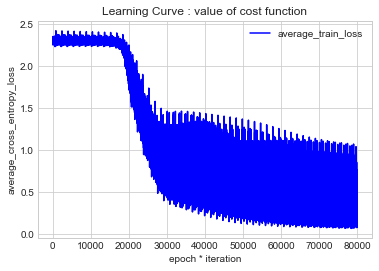

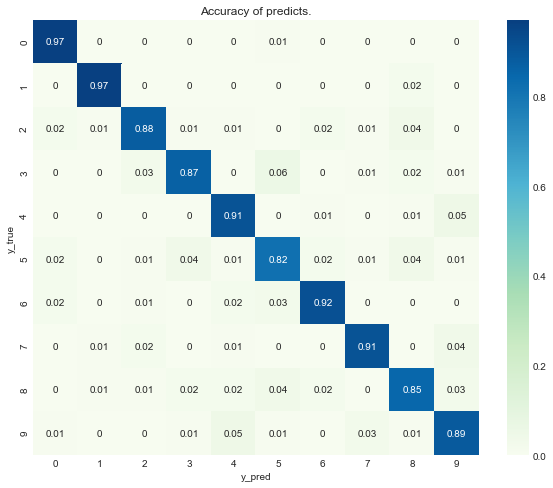

パターン : 2
活性化関数 : Sigmoid, 初期化 : Simple, 最適化手法 : AdaGrad



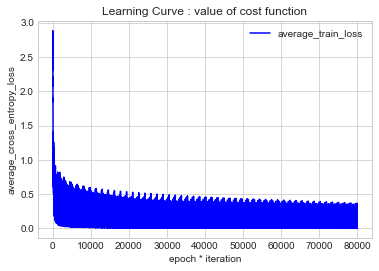

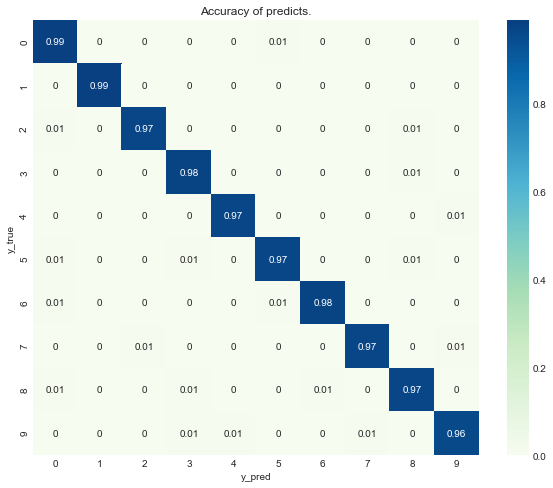

パターン : 3
活性化関数 : Sigmoid, 初期化 : Xavier, 最適化手法 : SGD



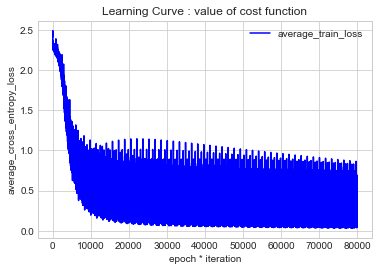

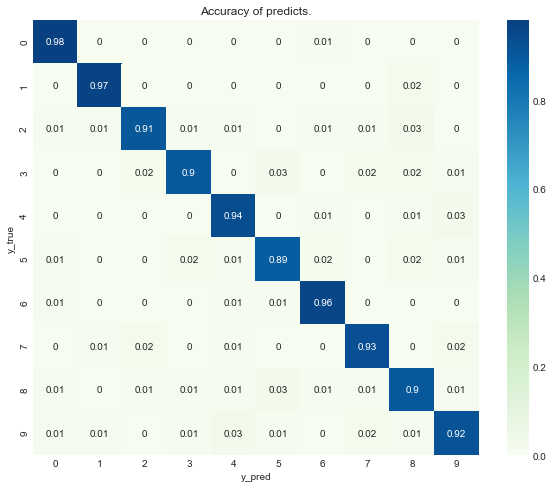

パターン : 4
活性化関数 : Sigmoid, 初期化 : Xavier, 最適化手法 : AdaGrad



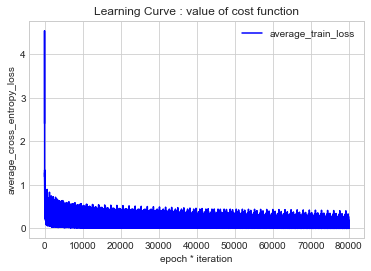

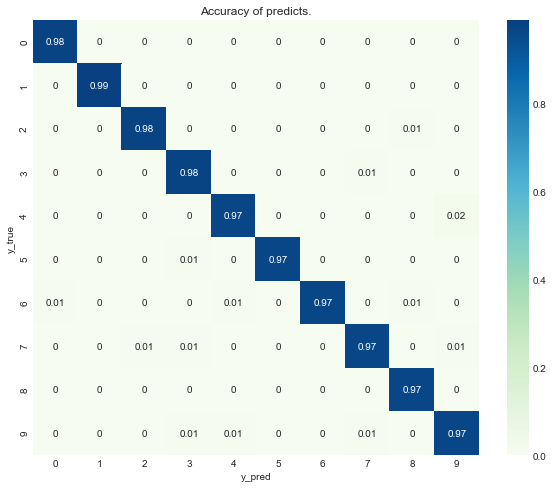

パターン : 5
活性化関数 : Sigmoid, 初期化 : He, 最適化手法 : SGD



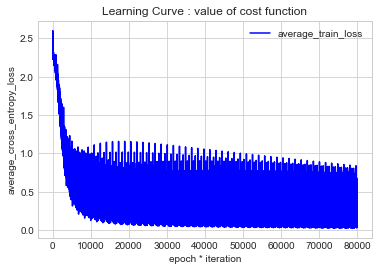

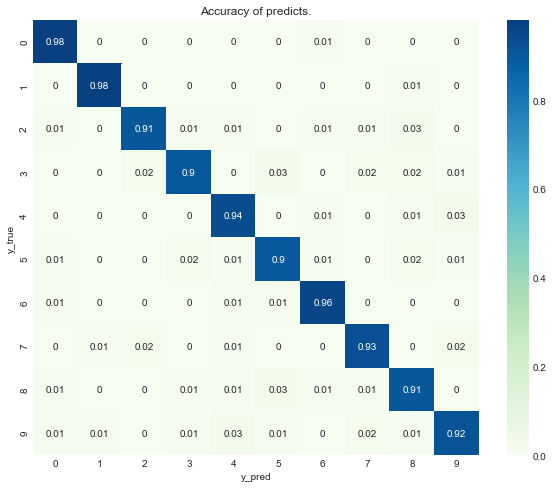

パターン : 6
活性化関数 : Sigmoid, 初期化 : He, 最適化手法 : AdaGrad



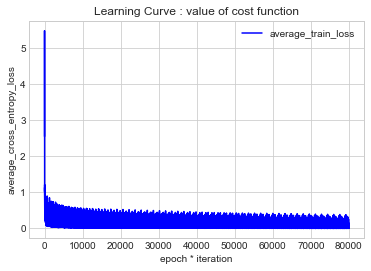

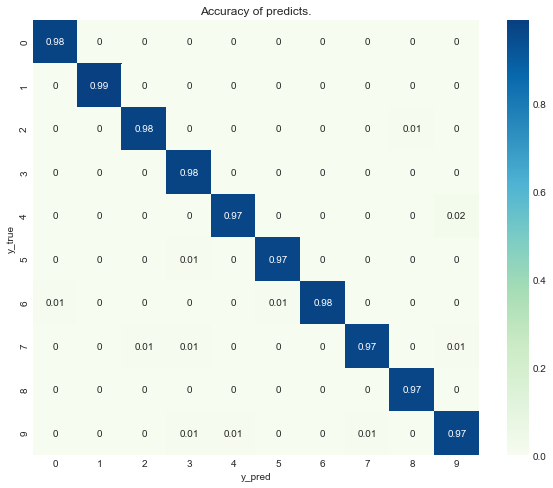

パターン : 7
活性化関数 : Tanh, 初期化 : Simple, 最適化手法 : SGD



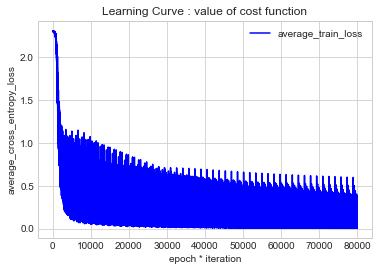

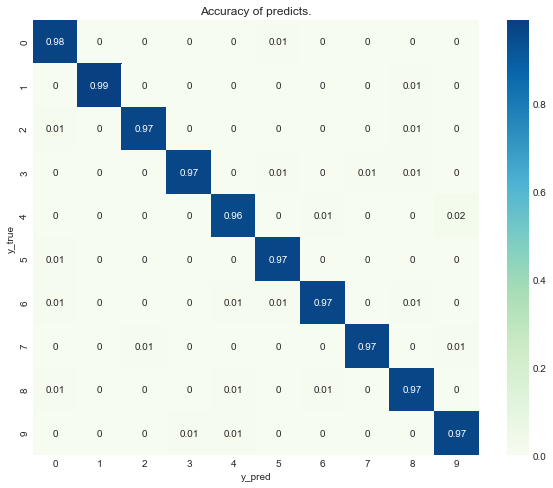

パターン : 8
活性化関数 : Tanh, 初期化 : Simple, 最適化手法 : AdaGrad



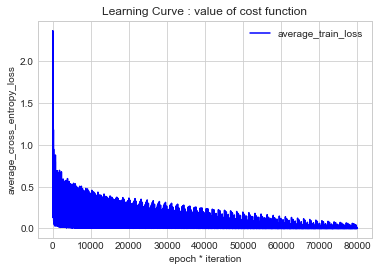

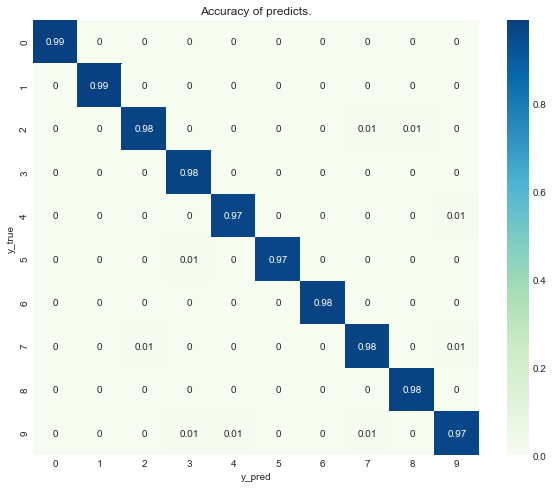

パターン : 9
活性化関数 : Tanh, 初期化 : Xavier, 最適化手法 : SGD



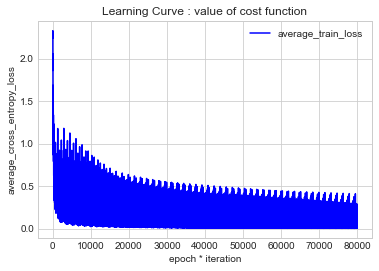

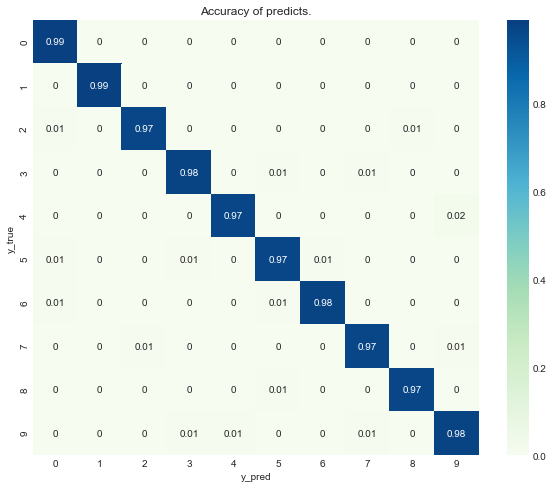

パターン : 10
活性化関数 : Tanh, 初期化 : Xavier, 最適化手法 : AdaGrad



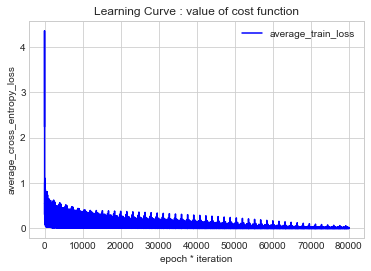

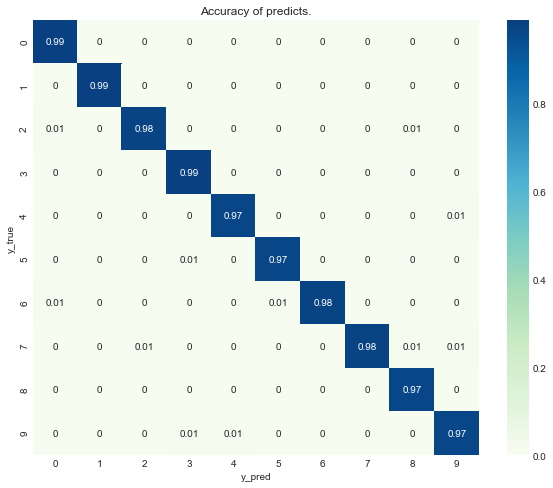

パターン : 11
活性化関数 : Tanh, 初期化 : He, 最適化手法 : SGD



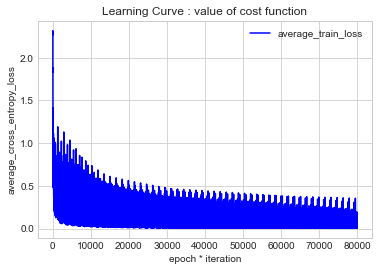

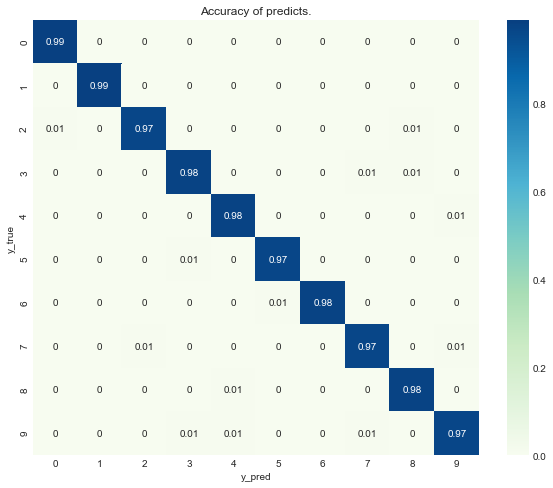

パターン : 12
活性化関数 : Tanh, 初期化 : He, 最適化手法 : AdaGrad



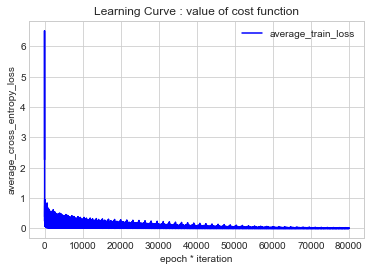

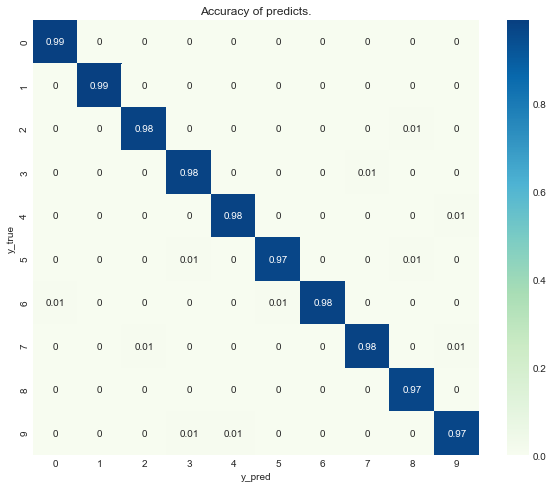

パターン : 13
活性化関数 : ReLU, 初期化 : Simple, 最適化手法 : SGD



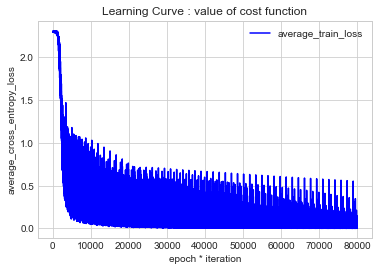

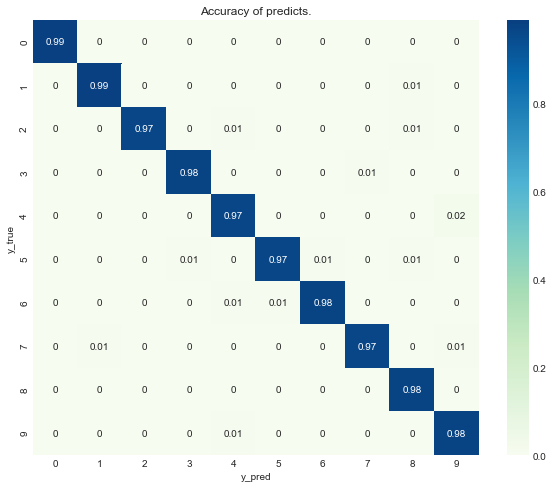

パターン : 14
活性化関数 : ReLU, 初期化 : Simple, 最適化手法 : AdaGrad



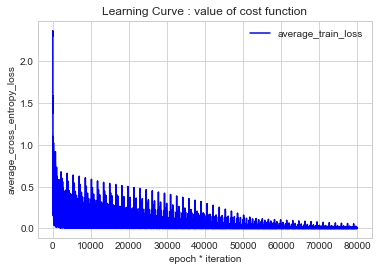

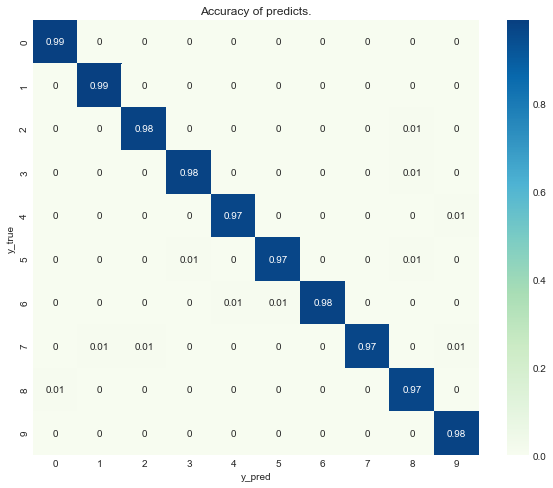

パターン : 15
活性化関数 : ReLU, 初期化 : Xavier, 最適化手法 : SGD



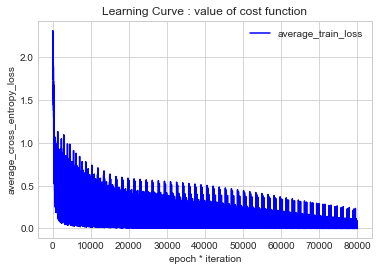

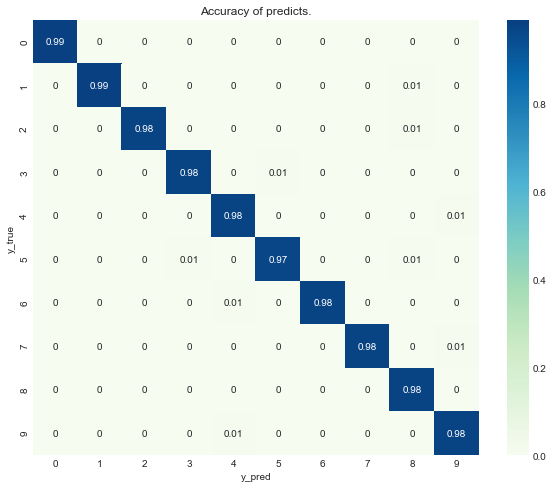

パターン : 16
活性化関数 : ReLU, 初期化 : Xavier, 最適化手法 : AdaGrad



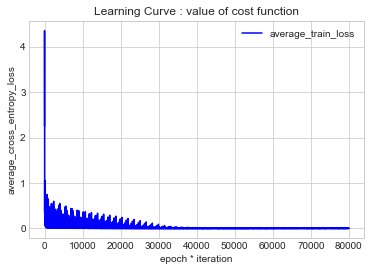

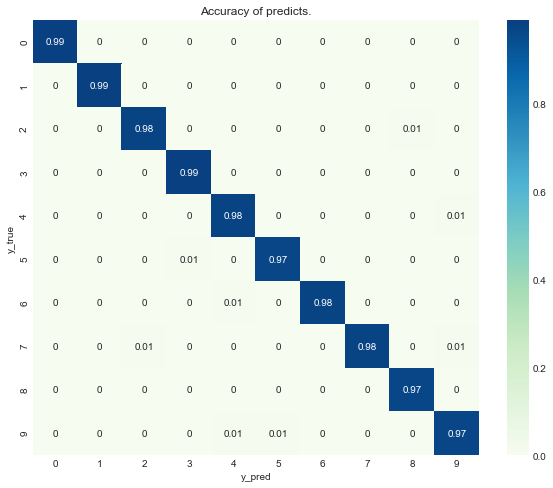

パターン : 17
活性化関数 : ReLU, 初期化 : He, 最適化手法 : SGD



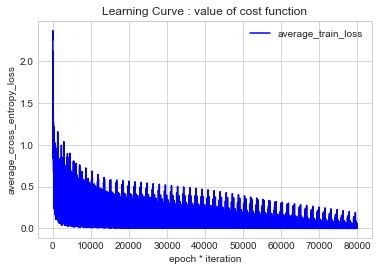

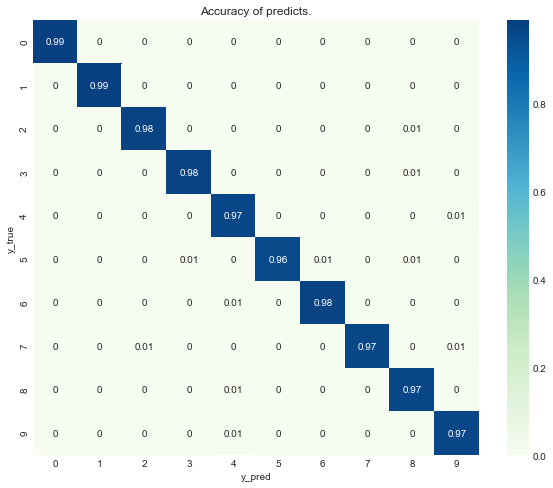

パターン : 18
活性化関数 : ReLU, 初期化 : He, 最適化手法 : AdaGrad



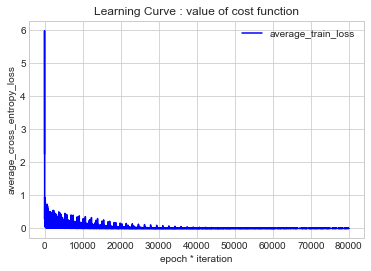

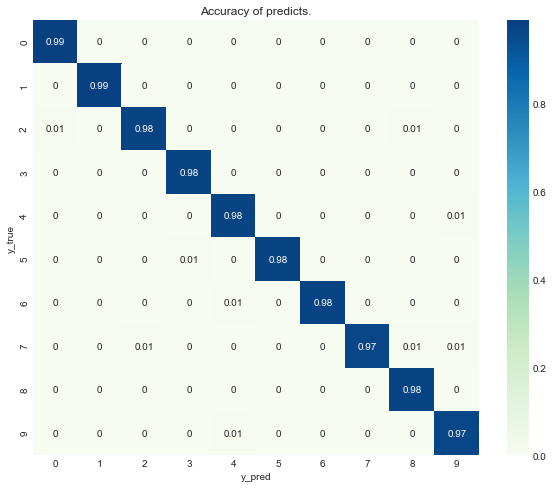

In [7]:
# ハイパーパラメータ
activations = ["Sigmoid", "Tanh", "ReLU"]
initializers = ["Simple", "Xavier", "He"]
optimizers = ["SGD", "AdaGrad"]

# パターン
pattern = 0

# 各ハイパーパラメータの組み合わせで学習、予測
for activation in activations:
    for initializer in initializers:
        for optimizer in optimizers:
            pattern +=1
            print("パターン : {}".format(pattern))
            print("活性化関数 : {0}, 初期化 : {1}, 最適化手法 : {2}".format(activation, initializer, optimizer))
            print("")
            
            clf = ScratchDeepNeuralNetworkClassifier(activation=activation, batch=30, initializer=initializer, n_epochs = 50, lr=1e-2,
                                                     n_nodes1=400, n_nodes2=200, optimizer=optimizer, sigma=0.01, verbose=False)
            
            clf.fit(X_train, y_train) # 学習
            clf.predict(X_test) # 正解値の予測
            clf.show_learning_curve() # 学習曲線を描画
            clf.show_accuracy(y_test) # 正解率の可視化

### Take away

1. 最適化手法、損失関数、初期化関数の組み合わせが、学習効率に影響を与える。
    - 特に、（Sigmoid, SGD, SimpleInitializer）の組み合わせでは、エポック数を小さくして試行した際に損失関数の値が下がらず、実装のミスがあると思い込んでしまった。（泥沼にはまった）
    - エポックを極度に少なくして損失が下がらない場合は、エポック数を十分に増やした上で再度試行することが肝要。


2. ニューラルネットワークの実装においては、入出力、及びパラメータのshapeが重要。
    - デバッグの際には、入出力のshapeをprintし、整合性を確認すること。